# Assignment 2

In this assigment, we will work with the *Forest Fire* data set. Please download the data from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/162/forest+fires). Extract the data files into the subdirectory: `../data/fires/` (relative to `./05_src/`).

## Objective

+ The model objective is to predict the area affected by forest fires given the features set. 
+ The objective of this exercise is to assess your ability to construct and evaluate model pipelines.
+ Please note: the instructions are not meant to be 100% prescriptive, but instead they are a set of minimum requirements. If you find predictive performance gains by applying additional steps, by all means show them. 

## Variable Description

From the description file contained in the archive (`forestfires.names`), we obtain the following variable descriptions:

1. X - x-axis spatial coordinate within the Montesinho park map: 1 to 9
2. Y - y-axis spatial coordinate within the Montesinho park map: 2 to 9
3. month - month of the year: "jan" to "dec" 
4. day - day of the week: "mon" to "sun"
5. FFMC - FFMC index from the FWI system: 18.7 to 96.20
6. DMC - DMC index from the FWI system: 1.1 to 291.3 
7. DC - DC index from the FWI system: 7.9 to 860.6 
8. ISI - ISI index from the FWI system: 0.0 to 56.10
9. temp - temperature in Celsius degrees: 2.2 to 33.30
10. RH - relative humidity in %: 15.0 to 100
11. wind - wind speed in km/h: 0.40 to 9.40 
12. rain - outside rain in mm/m2 : 0.0 to 6.4 
13. area - the burned area of the forest (in ha): 0.00 to 1090.84 









### Specific Tasks

+ Construct four model pipelines, out of combinations of the following components:

    + Preprocessors:

        - A simple processor that only scales numeric variables and recodes categorical variables.
        - A transformation preprocessor that scales numeric variables and applies a non-linear transformation.
    
    + Regressor:

        - A baseline regressor, which could be a [K-nearest neighbours model]() or a linear model like [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) or [Ridge Regressors](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ridge_regression.html).
        - An advanced regressor of your choice (e.g., Bagging, Boosting, SVR, etc.). TIP: select a tree-based method such that it does not take too long to run SHAP further below. 

+ Evaluate tune and evaluate each of the four model pipelines. 

    - Select a [performance metric](https://scikit-learn.org/stable/modules/linear_model.html) out of the following options: explained variance, max error, root mean squared error (RMSE), mean absolute error (MAE), r-squared.
    - *TIPS*: 
    
        * Out of the suggested metrics above, [some are correlation metrics, but this is a prediction problem](https://www.tmwr.org/performance#performance). Choose wisely (and don't choose the incorrect options.) 

+ Select the best-performing model and explain its predictions.

    - Provide local explanations.
    - Obtain global explanations and recommend a variable selection strategy.

+ Export your model as a pickle file.


You can work on the Jupyter notebook, as this experiment is fairly short (no need to use sacred). 

# Load the data

Place the files in the ../../05_src/data/fires/ directory and load the appropriate file. 

In [68]:
# Load the libraries as required.
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler,PowerTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from xgboost import XGBRegressor
import pickle
from sklearn.model_selection import GridSearchCV
import shap


c:\Users\darli\anaconda3\envs\dsi_participant\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
# Load data
columns = [
    'coord_x', 'coord_y', 'month', 'day', 'ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind', 'rain', 'area' 
]
fires_dt = (pd.read_csv('../../05_src/data/fires/forestfires.csv', header = 0, names = columns))
fires_dt.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   coord_x  517 non-null    int64  
 1   coord_y  517 non-null    int64  
 2   month    517 non-null    object 
 3   day      517 non-null    object 
 4   ffmc     517 non-null    float64
 5   dmc      517 non-null    float64
 6   dc       517 non-null    float64
 7   isi      517 non-null    float64
 8   temp     517 non-null    float64
 9   rh       517 non-null    int64  
 10  wind     517 non-null    float64
 11  rain     517 non-null    float64
 12  area     517 non-null    float64
dtypes: float64(8), int64(3), object(2)
memory usage: 52.6+ KB


In [10]:
fires_dt.describe()

,coord_x,coord_y,ffmc,dmc,dc,isi,temp,rh,wind,rain,area
count,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000
mean,4.669246,4.299807,90.644681,110.872340,547.940039,9.021663,18.889168,44.288201,4.017602,0.021663,12.847292
std,2.313778,1.229900,5.520111,64.046482,248.066192,4.559477,5.806625,16.317469,1.791653,0.295959,63.655818
min,1.000000,2.000000,18.700000,1.100000,7.900000,0.000000,2.200000,15.000000,0.400000,0.000000,0.000000
25%,3.000000,4.000000,90.200000,68.600000,437.700000,6.500000,15.500000,33.000000,2.700000,0.000000,0.000000
50%,4.000000,4.000000,91.600000,108.300000,664.200000,8.400000,19.300000,42.000000,4.000000,0.000000,0.520000
75%,7.000000,5.000000,92.900000,142.400000,713.900000,10.800000,22.800000,53.000000,4.900000,0.000000,6.570000
max,9.000000,9.000000,96.200000,291.300000,860.600000,56.100000,33.300000,100.000000,9.400000,6.400000,1090.840000


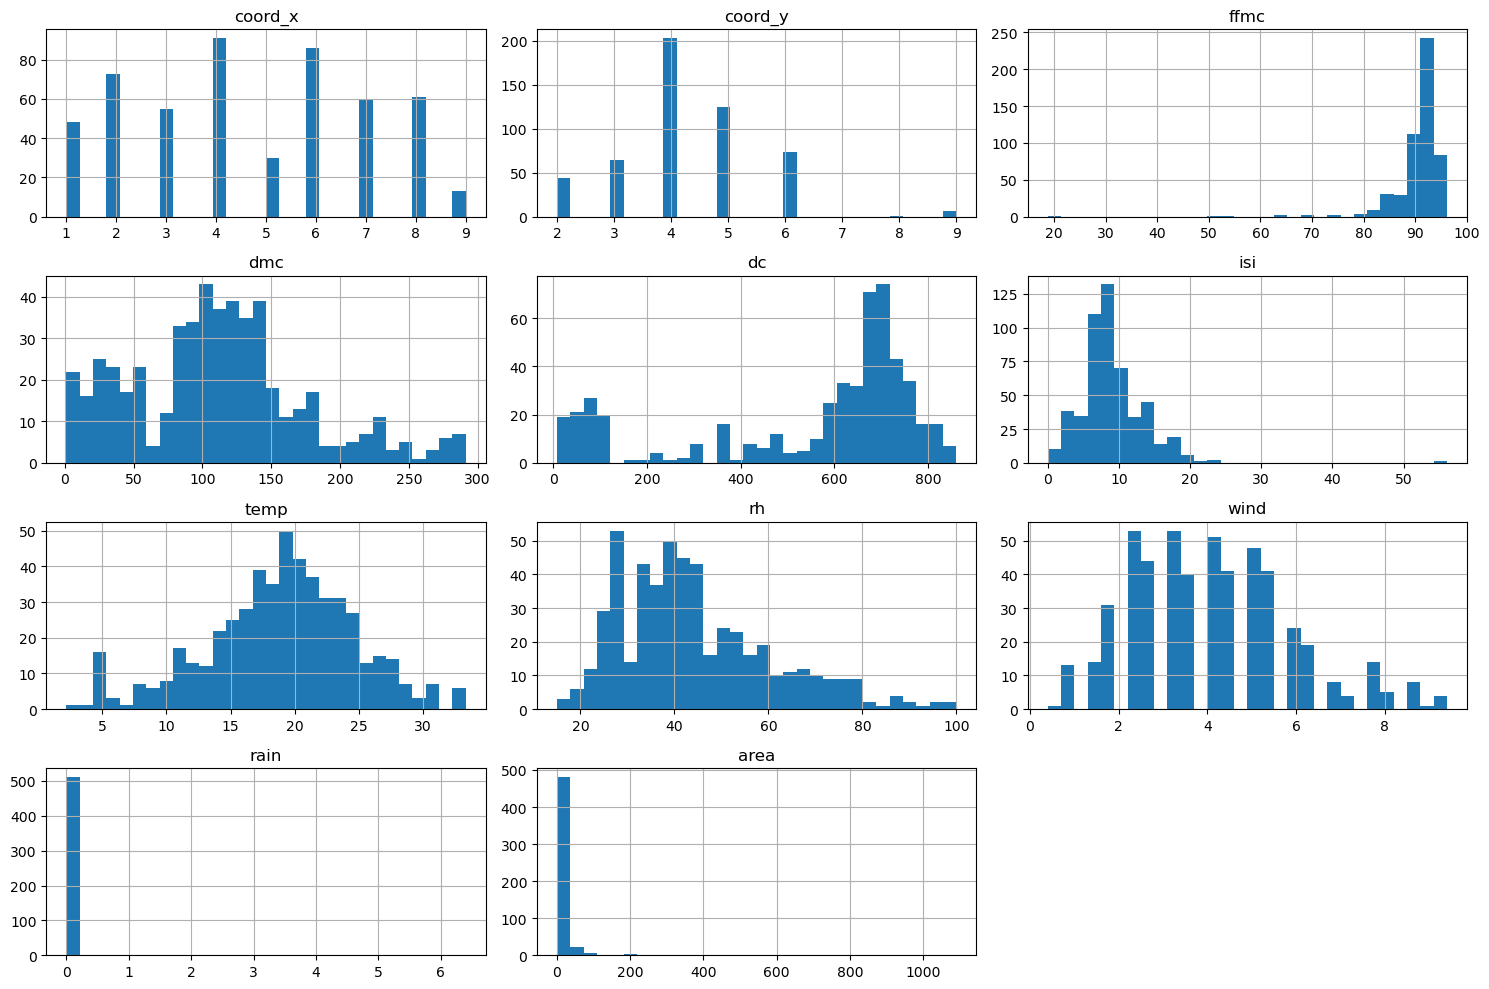

In [11]:
fires_dt.hist(bins=30, figsize=(15, 10))
plt.tight_layout()
plt.show()


ffmc and area has high skewnewss potentially to use the "Yeo-Johnson" transformation with the PowerTransformer 

# Get X and Y

Create the features data frame and target data.

In [12]:
# Schema
X = fires_dt[['coord_x', 'coord_y', 'month', 'day', 'ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind', 'rain']]
Y = fires_dt['area']

# Split the data
X_rest, X_test, Y_rest, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
X_train, X_validate, Y_train,  Y_validate = train_test_split(X_rest, Y_rest, test_size=0.2, random_state=42)

In [13]:
columns = ['coord_x', 'coord_y', 'month', 'day', 'ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind', 'rain', 'area']

## For preprocessing 1
num_cols = ['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind', 'rain']
cat_cols_onehot = ['month','day']

###For preprocessing 2
num_cols_wo_transform = ['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind', 'rain']
num_cols_transform = ['ffmc',]
cat_cols_onehot = ['month','day']


# Preprocessing

Create two [Column Transformers](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html), called preproc1 and preproc2, with the following guidelines:

- Numerical variables

    * (Preproc 1 and 2) Scaling: use a scaling method of your choice (Standard, Robust, Min-Max). 
    * Preproc 2 only: 
        
        + Choose a transformation for any of your input variables (or several of them). Evaluate if this transformation is convenient.
        + The choice of scaler is up to you.

- Categorical variables: 
    
    * (Preproc 1 and 2) Apply [one-hot encoding](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) where appropriate.


+ The only difference between preproc1 and preproc2 is the non-linear transformation of the numerical variables.
    


### Preproc 1

Create preproc1 below.

+ Numeric: scaled variables, no other transforms.
+ Categorical: one-hot encoding.

In [33]:
preprocessing1 = ColumnTransformer(
    transformers=[
        ('numericals', StandardScaler(), num_cols),
        ('onehot', OneHotEncoder(handle_unknown='ignore'), cat_cols_onehot)
    ]
)

preprocessing1

ColumnTransformer(transformers=[('numericals', StandardScaler(),
                                 ['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc',
                                  'isi', 'temp', 'rh', 'wind', 'rain']),
                                ('onehot',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 ['month', 'day'])])

### Preproc 2

Create preproc1 below.

+ Numeric: scaled variables, non-linear transformation to one or more variables.
+ Categorical: one-hot encoding.

In [34]:
pipe_num_yj = Pipeline([
    ('standardizer', StandardScaler()),
    ('transform', PowerTransformer(method='yeo-johnson'))
])


preprocessing2 = ColumnTransformer(
    transformers=[
        ('numeric_std', StandardScaler(), num_cols_wo_transform),
        ('numeric_yj', pipe_num_yj, num_cols_transform),
        ('onehot', OneHotEncoder(handle_unknown='ignore'), cat_cols_onehot)
    ]   
)
preprocessing2

ColumnTransformer(transformers=[('numeric_std', StandardScaler(),
                                 ['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc',
                                  'isi', 'temp', 'rh', 'wind', 'rain']),
                                ('numeric_yj',
                                 Pipeline(steps=[('standardizer',
                                                  StandardScaler()),
                                                 ('transform',
                                                  PowerTransformer())]),
                                 ['ffmc']),
                                ('onehot',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 ['month', 'day'])])

## Model Pipeline


Create a [model pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html): 

+ Add a step labelled `preprocessing` and assign the Column Transformer from the previous section.
+ Add a step labelled `regressor` and assign a regression model to it. 

## Regressor

+ Use a regression model to perform a prediction. 

    - Choose a baseline regressor, tune it (if necessary) using grid search, and evaluate it using cross-validation.
    - Choose a more advance regressor, tune it (if necessary) using grid search, and evaluate it using cross-validation.
    - Both model choices are up to you, feel free to experiment.

In [35]:
# Pipeline A = preproc1 + baseline
pipe_a = Pipeline([
    ('preprocessing', preprocessing1),
    ('regressor', Lasso())
])
pipe_a

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('numericals',
                                                  StandardScaler(),
                                                  ['coord_x', 'coord_y', 'ffmc',
                                                   'dmc', 'dc', 'isi', 'temp',
                                                   'rh', 'wind', 'rain']),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['month', 'day'])])),
                ('regressor', Lasso())])

In [36]:
# Pipeline B = preproc2 + baseline
pipe_b = Pipeline([
    ('preprocessing', preprocessing2),
    ('regressor', Lasso())
])
pipe_b

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('numeric_std',
                                                  StandardScaler(),
                                                  ['coord_x', 'coord_y', 'ffmc',
                                                   'dmc', 'dc', 'isi', 'temp',
                                                   'rh', 'wind', 'rain']),
                                                 ('numeric_yj',
                                                  Pipeline(steps=[('standardizer',
                                                                   StandardScaler()),
                                                                  ('transform',
                                                                   PowerTransformer())]),
                                                  ['ffmc']),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['month', 'day'])])),
                ('regressor', Lasso())])

In [37]:
# Pipeline C = preproc1 + advanced model
pipe_c = Pipeline([
    ('preprocessing', preprocessing1),
    ('regressor', XGBRegressor())
])
pipe_c

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('numericals',
                                                  StandardScaler(),
                                                  ['coord_x', 'coord_y', 'ffmc',
                                                   'dmc', 'dc', 'isi', 'temp',
                                                   'rh', 'wind', 'rain']),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['month', 'day'])])),
                ('regressor',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=No...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...))])

In [38]:
# Pipeline D = preproc2 + advanced model

pipe_d = Pipeline([
    ('preprocessing', preprocessing2),
    ('regressor', XGBRegressor())
])
pipe_d

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('numeric_std',
                                                  StandardScaler(),
                                                  ['coord_x', 'coord_y', 'ffmc',
                                                   'dmc', 'dc', 'isi', 'temp',
                                                   'rh', 'wind', 'rain']),
                                                 ('numeric_yj',
                                                  Pipeline(steps=[('standardizer',
                                                                   StandardScaler()),
                                                                  ('transform',
                                                                   PowerTransformer())]),
                                                  ['ffmc']),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['month', 'day'])])),
                ('...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...))])

In [61]:
#Saving all the pipelines as pickles

with open('pipe_a.pkl', 'wb') as f:
    pickle.dump(pipe_a, f)

with open('pipe_b.pkl', 'wb') as f:
    pickle.dump(pipe_b, f)

with open('pipe_c.pkl', 'wb') as f:
    pickle.dump(pipe_c, f)

with open('pipe_d.pkl', 'wb') as f:
    pickle.dump(pipe_d, f)


# Tune Hyperparams

+ Perform GridSearch on each of the four pipelines. 
+ Tune at least one hyperparameter per pipeline.
+ Experiment with at least four value combinations per pipeline.

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html


https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.XGBRegressor

In [45]:
param_grid_lasso = {
    'regressor__alpha': [0.01, 0.1],
    'regressor__max_iter': [1000, 5000],
    'regressor__tol': [1e-4, 1e-3]
}

param_grid_xgb = {
    'regressor__n_estimators': [100, 200],
    'regressor__max_depth': [3, 6],
    'regressor__learning_rate': [0.01, 0.1]
}

In [50]:
#Grid Search for Pipeline A
###########################

#As described we cannot use r2 neither variance
scoring = 'neg_mean_absolute_error'  # O 'neg_root_mean_squared_error'
grid_cv_a = GridSearchCV(
    estimator=pipe_a, 
    param_grid=param_grid_lasso, 
    scoring=scoring, 
    cv=5
)
grid_cv_a.fit(X_train, Y_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('numericals',
                                                                         StandardScaler(),
                                                                         ['coord_x',
                                                                          'coord_y',
                                                                          'ffmc',
                                                                          'dmc',
                                                                          'dc',
                                                                          'isi',
                                                                          'temp',
                                                                          'rh',
                                                                          'wind',
                                                                          'rain']),
                                                                        ('onehot',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['month',
                                                                          'day'])])),
                                       ('regressor', Lasso())]),
             param_grid={'regressor__alpha': [0.01, 0.1],
                         'regressor__max_iter': [1000, 5000],
                         'regressor__tol': [0.0001, 0.001]},
             scoring='neg_mean_absolute_error')

In [51]:
grid_cv_a.best_params_

{'regressor__alpha': 0.1, 'regressor__max_iter': 1000, 'regressor__tol': 0.001}

In [53]:
#Grid Search for Pipeline B
###########################

#As described we cannot use r2 neither variance
scoring = 'neg_mean_absolute_error'  # O 'neg_root_mean_squared_error'
grid_cv_b = GridSearchCV(
    estimator=pipe_b, 
    param_grid=param_grid_lasso, 
    scoring=scoring, 
    cv=5
)
grid_cv_b.fit(X_train, Y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('numeric_std',
                                                                         StandardScaler(),
                                                                         ['coord_x',
                                                                          'coord_y',
                                                                          'ffmc',
                                                                          'dmc',
                                                                          'dc',
                                                                          'isi',
                                                                          'temp',
                                                                          'rh',
                                                                          'wind',
                                                                          'rain']),
                                                                        ('numeric_yj',
                                                                         Pipeline(steps=[('standardizer',
                                                                                          StandardScaler()),
                                                                                         ('transform',
                                                                                          PowerTransformer())]),
                                                                         ['ffmc']),
                                                                        ('onehot',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['month',
                                                                          'day'])])),
                                       ('regressor', Lasso())]),
             param_grid={'regressor__alpha': [0.01, 0.1],
                         'regressor__max_iter': [1000, 5000],
                         'regressor__tol': [0.0001, 0.001]},
             scoring='neg_mean_absolute_error')

In [54]:
grid_cv_b.best_params_

{'regressor__alpha': 0.1, 'regressor__max_iter': 1000, 'regressor__tol': 0.001}

In [55]:
#Grid Search for Pipeline C
###########################

#As described we cannot use r2 neither variance
scoring = 'neg_mean_absolute_error'  # O 'neg_root_mean_squared_error'
grid_cv_c = GridSearchCV(
    estimator=pipe_c, 
    param_grid=param_grid_xgb, 
    scoring=scoring, 
    cv=5
)
grid_cv_c.fit(X_train, Y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('numericals',
                                                                         StandardScaler(),
                                                                         ['coord_x',
                                                                          'coord_y',
                                                                          'ffmc',
                                                                          'dmc',
                                                                          'dc',
                                                                          'isi',
                                                                          'temp',
                                                                          'rh',
                                                                          'wind',
                                                                          'rain']),
                                                                        ('onehot',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['month',
                                                                          'day'])])),
                                       ('regressor',
                                        XGBRegressor(base_score=None,
                                                     booster=None,
                                                     callbacks=None,
                                                     colsample_byle...
                                                     max_delta_step=None,
                                                     max_depth=None,
                                                     max_leaves=None,
                                                     min_child_weight=None,
                                                     missing=nan,
                                                     monotone_constraints=None,
                                                     multi_strategy=None,
                                                     n_estimators=None,
                                                     n_jobs=None,
                                                     num_parallel_tree=None,
                                                     random_state=None, ...))]),
             param_grid={'regressor__learning_rate': [0.01, 0.1],
                         'regressor__max_depth': [3, 6],
                         'regressor__n_estimators': [100, 200]},
             scoring='neg_mean_absolute_error')

In [56]:
grid_cv_c.best_params_

{'regressor__learning_rate': 0.01,
 'regressor__max_depth': 3,
 'regressor__n_estimators': 100}

In [57]:
#Grid Search for Pipeline D
###########################

#As described we cannot use r2 neither variance
scoring = 'neg_mean_absolute_error'  # O 'neg_root_mean_squared_error'
grid_cv_d = GridSearchCV(
    estimator=pipe_d, 
    param_grid=param_grid_xgb, 
    scoring=scoring, 
    cv=5
)
grid_cv_d.fit(X_train, Y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('numeric_std',
                                                                         StandardScaler(),
                                                                         ['coord_x',
                                                                          'coord_y',
                                                                          'ffmc',
                                                                          'dmc',
                                                                          'dc',
                                                                          'isi',
                                                                          'temp',
                                                                          'rh',
                                                                          'wind',
                                                                          'rain']),
                                                                        ('numeric_yj',
                                                                         Pipeline(steps=[('standardizer',
                                                                                          StandardScaler()),
                                                                                         ('transform',
                                                                                          PowerTransformer())]),
                                                                         ['ffmc']),
                                                                        ('onehot',
                                                                         OneHotEncoder(handle_unknown='ign...
                                                     max_delta_step=None,
                                                     max_depth=None,
                                                     max_leaves=None,
                                                     min_child_weight=None,
                                                     missing=nan,
                                                     monotone_constraints=None,
                                                     multi_strategy=None,
                                                     n_estimators=None,
                                                     n_jobs=None,
                                                     num_parallel_tree=None,
                                                     random_state=None, ...))]),
             param_grid={'regressor__learning_rate': [0.01, 0.1],
                         'regressor__max_depth': [3, 6],
                         'regressor__n_estimators': [100, 200]},
             scoring='neg_mean_absolute_error')

In [58]:
grid_cv_d.best_params_

{'regressor__learning_rate': 0.01,
 'regressor__max_depth': 3,
 'regressor__n_estimators': 100}

# Evaluate

+ Which model has the best performance?

In [64]:
best_score_a = abs(grid_cv_a.best_score_)
best_score_b = abs(grid_cv_b.best_score_)
best_score_c = abs(grid_cv_c.best_score_)
best_score_d = abs(grid_cv_d.best_score_)   

print(f'Best score for Pipeline A: {best_score_a}')
print(f'Best score for Pipeline B: {best_score_b}')
print(f'Best score for Pipeline C: {best_score_c}')
print(f'Best score for Pipeline D: {best_score_d}')

Best score for Pipeline A: 20.612600524839706
Best score for Pipeline B: 20.598543178035243
Best score for Pipeline C: 18.72758733697371
Best score for Pipeline D: 18.72758733697371


As we can see, and based on the 5 folds we ran and by using the RMSE as the error metric (because is a prediction project and not a correlation problem, they normally use R2 or covariance).

Pipeline C and D has the same lowest performance 18.73 (furthermore they achieved with the same XGBoost hyperparameter set). Therefore, I could select Pipeline C (XGBoost) as the best performing model.

# Export

+ Save the best performing model to a pickle file.

In [65]:
best_model_c = grid_cv_c.best_estimator_

# This part save my best model
with open('best_pipeline_c.pkl', 'wb') as f:
    pickle.dump(best_model_c, f)

print("Best model (Pipeline C) exported successfully as 'best_pipeline_c.pkl'.")

Best model (Pipeline C) exported successfully as 'best_pipeline_c.pkl'.


In [67]:
best_model_c = grid_cv_c.best_estimator_
best_model_c

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('numericals',
                                                  StandardScaler(),
                                                  ['coord_x', 'coord_y', 'ffmc',
                                                   'dmc', 'dc', 'isi', 'temp',
                                                   'rh', 'wind', 'rain']),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['month', 'day'])])),
                ('regressor',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=No...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.01,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=3, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=100, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...))])

# Explain

+ Use SHAP values to explain the following only for the best-performing model:

    - Select an observation in your test set and explain which are the most important features that explain that observation's specific prediction.

    - In general, across the complete training set, which features are the most and least important.

+ If you were to remove features from the model, which ones would you remove? Why? How would you test that these features are actually enhancing model performance?

In [70]:
best_model_c.named_steps['preprocessing']

ColumnTransformer(transformers=[('numericals', StandardScaler(),
                                 ['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc',
                                  'isi', 'temp', 'rh', 'wind', 'rain']),
                                ('onehot',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 ['month', 'day'])])

In [74]:
# 1. First I need to remove the preprocessing step from the pipeline and then transform test data with the pipeline's preprocessing step

data_transform = best_model_c.named_steps['preprocessing'].transform(X_test)
data_transform

array([[ 0.60189977,  0.61006044, -0.89853571, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.03844246,  0.61006044,  0.92659138, ...,  0.        ,
         1.        ,  0.        ],
       [ 1.47498515,  1.46674105,  0.2629088 , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.16535708, -0.24662018,  0.08039609, ...,  0.        ,
         0.        ,  0.        ],
       [-1.14427099, -0.24662018, -1.47925797, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.60189977, -1.10330079,  0.37905326, ...,  1.        ,
         0.        ,  0.        ]])

In [89]:
# 2. Get the feature names after we preprocess the data
feature_names = best_model_c.named_steps['preprocessing'].get_feature_names_out()
feature_names

array(['numericals__coord_x', 'numericals__coord_y', 'numericals__ffmc',
       'numericals__dmc', 'numericals__dc', 'numericals__isi',
       'numericals__temp', 'numericals__rh', 'numericals__wind',
       'numericals__rain', 'onehot__month_apr', 'onehot__month_aug',
       'onehot__month_dec', 'onehot__month_feb', 'onehot__month_jan',
       'onehot__month_jul', 'onehot__month_jun', 'onehot__month_mar',
       'onehot__month_may', 'onehot__month_nov', 'onehot__month_oct',
       'onehot__month_sep', 'onehot__day_fri', 'onehot__day_mon',
       'onehot__day_sat', 'onehot__day_sun', 'onehot__day_thu',
       'onehot__day_tue', 'onehot__day_wed'], dtype=object)

In [85]:
# 3. Lets create the SHAP explainer for XGBoost (as the 06_explainibility notebook mention for my XGBoost, TreeExplainer is recommended)
explainer = shap.TreeExplainer(best_model_c.named_steps['regressor'])

In [86]:
# 4. Calculate SHAP as an explanation object (with the features names we collected) for the values for the transformed test data
shap_values = explainer(data_transform)
shap_values.feature_names = feature_names
shap_values


.values =
array([[-1.9487331 ,  0.        ,  0.20684303, ...,  0.        ,
         0.        ,  0.        ],
       [-0.8575384 ,  0.        , -0.18704693, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.9824026 ,  0.        , -0.18704693, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.6906317 ,  0.        , -0.05476104, ...,  0.        ,
         0.        ,  0.        ],
       [-2.0632453 ,  0.        ,  0.20684303, ...,  0.        ,
         0.        ,  0.        ],
       [-1.75298   ,  0.        , -0.05476104, ...,  0.        ,
         0.        ,  0.        ]], dtype=float32)

.base_values =
array([11.815939, 11.815939, 11.815939, 11.815939, 11.815939, 11.815939,
       11.815939, 11.815939, 11.815939, 11.815939, 11.815939, 11.815939,
       11.815939, 11.815939, 11.815939, 11.815939, 11.815939, 11.815939,
       11.815939, 11.815939, 11.815939, 11.815939, 11.815939, 11.815939,
       11.815939, 11.815939, 11.815939, 11.815939, 11.

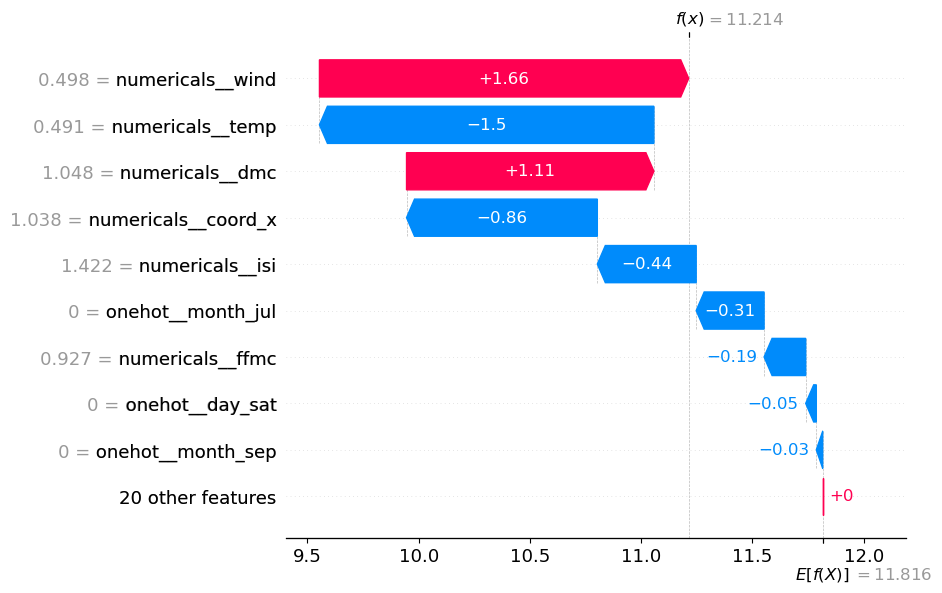

In [92]:

#LOCAL EXPLANATION
# 5. Now I will display the waterfall plot just for a single observation (e.g., second observation/record with the index 1)
shap.plots.waterfall(shap_values[1])

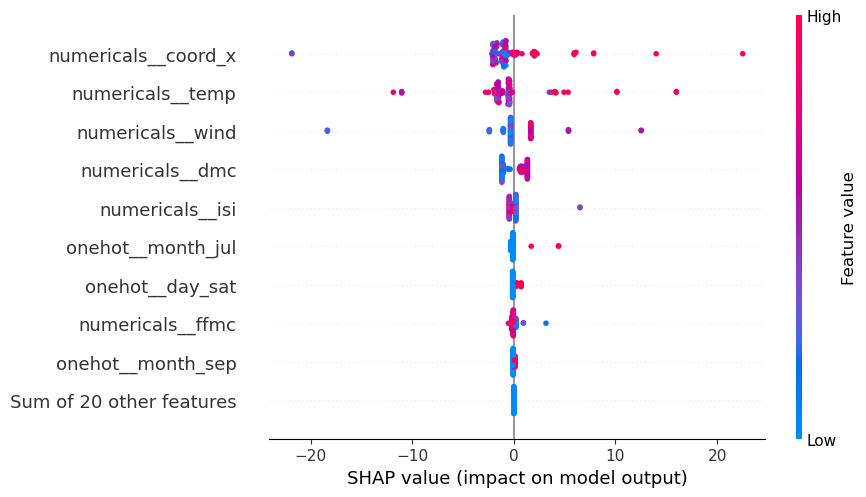

In [ ]:
#GLOBAL EXPLANATION
# 6. Beeswarm plot for global explanation
shap.plots.beeswarm(shap_values)

The last line "Sum of 20 other features" has almost impercitible contribution to the prediction, so we could try to remove them, train and test again and check one more time the performance to confirm that we could delete those 20 features.

"Sum of 20 other features" = feature_names - "values show it in this global explanation"

"Sum of 20 other features" = 
[]'numericals__coord_y','numericals__dc', 'numericals__rh','numericals__rain', 'onehot__month_apr', 'onehot__month_aug',
'onehot__month_dec', 'onehot__month_feb', 'onehot__month_jan', 'onehot__month_jun', 'onehot__month_mar', 'onehot__month_may', 
'onehot__month_nov', 'onehot__month_oct', 'onehot__day_fri', 'onehot__day_mon', 'onehot__day_sun', 'onehot__day_thu',
'onehot__day_tue', 'onehot__day_wed']


       

In [ ]:
import numpy as np

# we can calculate mean absolute SHAP value for each feature
mean_abs_shap = np.mean(np.abs(shap_values.values), axis=0)
percent_contrib = 100 * mean_abs_shap / np.sum(mean_abs_shap)

# Get sorted indices in descending order
sorted_idx = np.argsort(percent_contrib)[::-1]  # [::-1] reverses for descending order[1][3][6][7]

# Print features sorted by importance
for idx in sorted_idx:
    print(f"{feature_names[idx]}: {percent_contrib[idx]:.1f}%")


numericals__coord_x: 27.6%
numericals__temp: 25.8%
numericals__wind: 21.7%
numericals__dmc: 12.8%
numericals__isi: 4.6%
onehot__month_jul: 3.0%
onehot__day_sat: 1.9%
numericals__ffmc: 1.9%
onehot__month_sep: 0.7%
onehot__month_dec: 0.0%
numericals__coord_y: 0.0%
numericals__dc: 0.0%
numericals__rh: 0.0%
numericals__rain: 0.0%
onehot__month_apr: 0.0%
onehot__month_aug: 0.0%
onehot__day_wed: 0.0%
onehot__month_feb: 0.0%
onehot__day_tue: 0.0%
onehot__month_jun: 0.0%
onehot__month_mar: 0.0%
onehot__month_may: 0.0%
onehot__month_nov: 0.0%
onehot__month_oct: 0.0%
onehot__day_fri: 0.0%
onehot__day_mon: 0.0%
onehot__day_sun: 0.0%
onehot__day_thu: 0.0%
onehot__month_jan: 0.0%


on average we could say that "numericals_coord_x" accounts 27.6% of my predictive power for the dataset, and so on... 

Also here we can see the last one "onehot_month_sep account 0.7% of my predictive power for the dataset, the other 20 are candidates to analyze and delete 

## Criteria

The [rubric](./assignment_2_rubric_clean.xlsx) contains the criteria for assessment.

## Submission Information

🚨 **Please review our [Assignment Submission Guide](https://github.com/UofT-DSI/onboarding/blob/main/onboarding_documents/submissions.md)** 🚨 for detailed instructions on how to format, branch, and submit your work. Following these guidelines is crucial for your submissions to be evaluated correctly.

### Submission Parameters:
* Submission Due Date: `HH:MM AM/PM - DD/MM/YYYY`
* The branch name for your repo should be: `assignment-2`
* What to submit for this assignment:
    * This Jupyter Notebook (assignment_2.ipynb) should be populated and should be the only change in your pull request.
* What the pull request link should look like for this assignment: `https://github.com/<your_github_username>/production/pull/<pr_id>`
    * Open a private window in your browser. Copy and paste the link to your pull request into the address bar. Make sure you can see your pull request properly. This helps the technical facilitator and learning support staff review your submission easily.

Checklist:
- [ ] Created a branch with the correct naming convention.
- [ ] Ensured that the repository is public.
- [ ] Reviewed the PR description guidelines and adhered to them.
- [ ] Verify that the link is accessible in a private browser window.

If you encounter any difficulties or have questions, please don't hesitate to reach out to our team via our Slack at the `help` channel. Our Technical Facilitators and Learning Support staff are here to help you navigate any challenges.

# Reference

Cortez,Paulo and Morais,Anbal. (2008). Forest Fires. UCI Machine Learning Repository. https://doi.org/10.24432/C5D88D.